
|                    FASE 1: CONFIGURAÇÃO E CARGA DE DADOS                     |
 -> Dataset 'Pima Indians Diabetes' carregado com sucesso.
 -> Dimensões iniciais: 768 amostras e 9 colunas.

 -> Verificando e tratando valores ausentes (representados por '0')...
 -> Contagem de valores nulos após substituição:
Nº de Gestações                     0
Concentração de Glicose             5
Pressão Arterial (mmHg)            35
Espessura da Pele (mm)            227
Nível de Insulina (mu U/ml)       374
Índice de Massa Corporal           11
Histórico Familiar de Diabetes      0
Idade (anos)                        0
Classe                              0
dtype: int64

|                 FASE 2: ANÁLISE EXPLORATÓRIA DE DADOS (EDA)                  |

--- Distribuição das Features por Classe ---


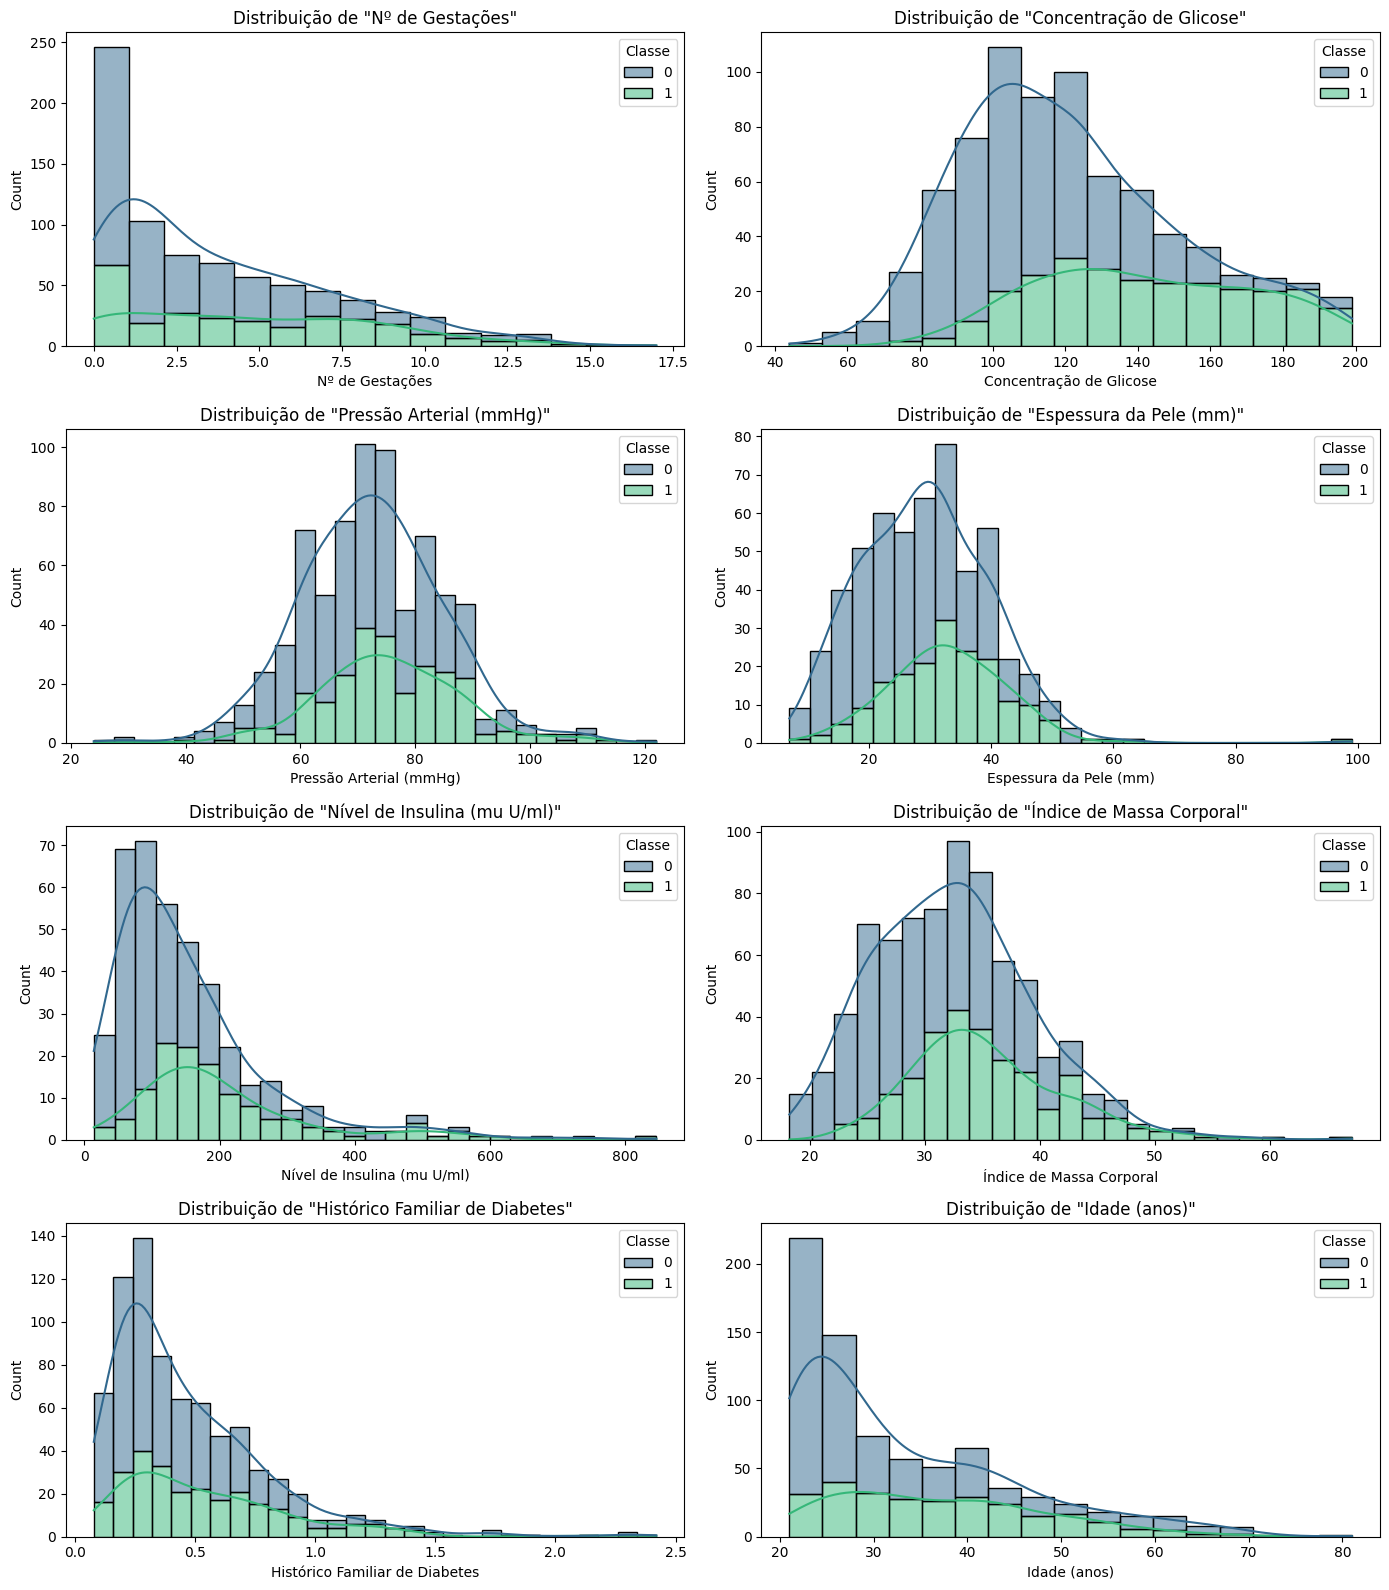


--- Heatmap de Correlação entre as Features ---


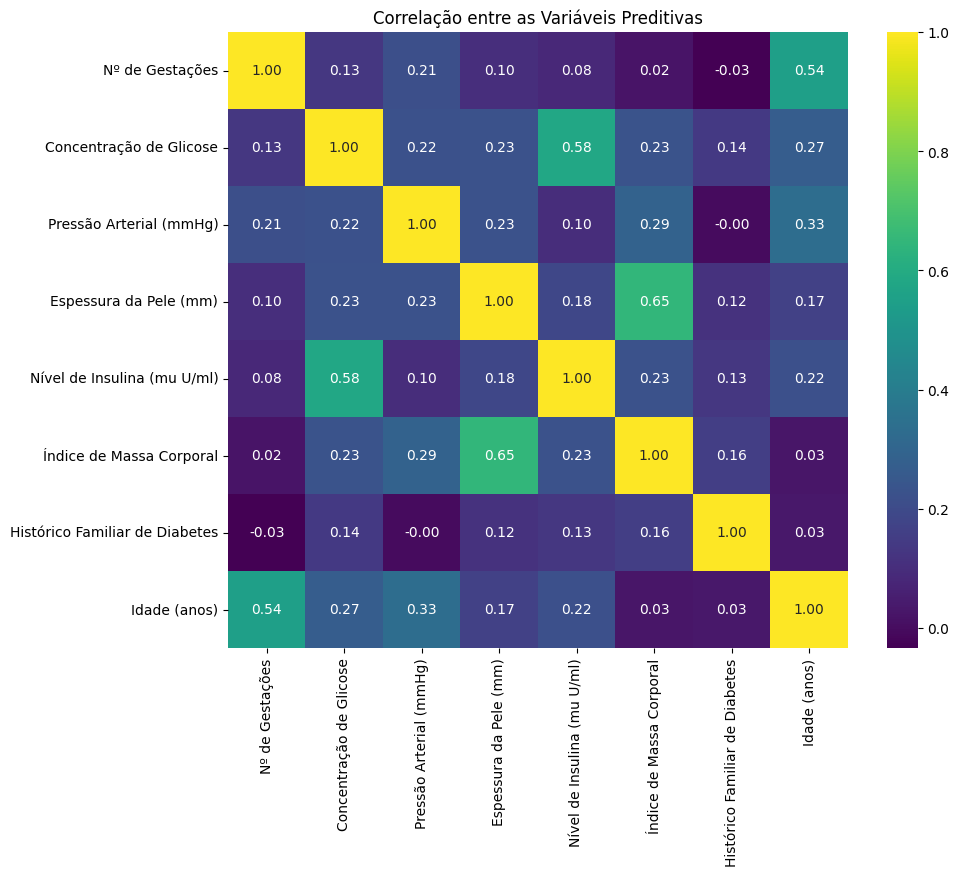


|                   FASE 3: EXECUÇÃO DA ANÁLISE COMPARATIVA                    |

--- Analisando com a estratégia: K-Fold (10 splits) ---
 -> Buscando melhores hiperparâmetros com GridSearchCV...
 -> Busca concluída.

   - Acurácia Média: 0.7656 (±0.0486)
   - ROC AUC Médio: 0.8357
   - Melhores Hiperparâmetros: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
 -> Gerando predições com cross_val_predict para uma matriz de confusão mais precisa...


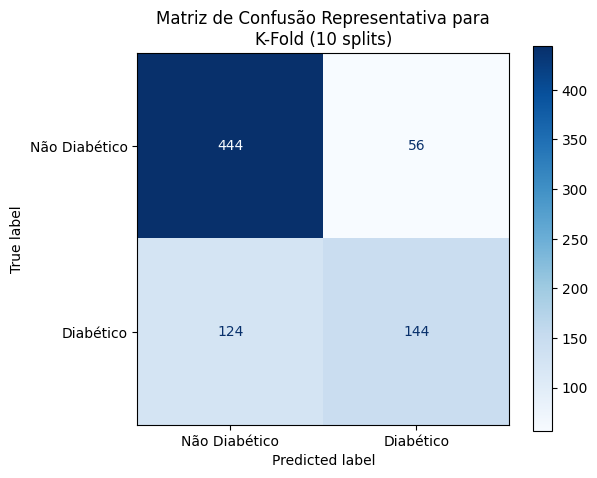


--- Analisando com a estratégia: Repeated Stratified K-Fold (20x2) ---
 -> Buscando melhores hiperparâmetros com GridSearchCV...
 -> Busca concluída.

   - Acurácia Média: 0.7663 (±0.0680)
   - ROC AUC Médio: 0.8368
   - Melhores Hiperparâmetros: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
 -> Gerando predições com cross_val_predict para uma matriz de confusão mais precisa...
    (Aviso) Usando StratifiedKFold com 40 splits para gerar a matriz de confusão.


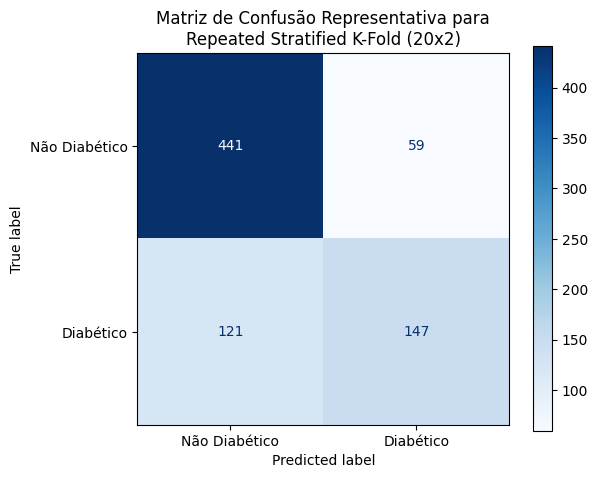


|               FASE 4: ANÁLISE COMPARATIVA FINAL DOS RESULTADOS               |


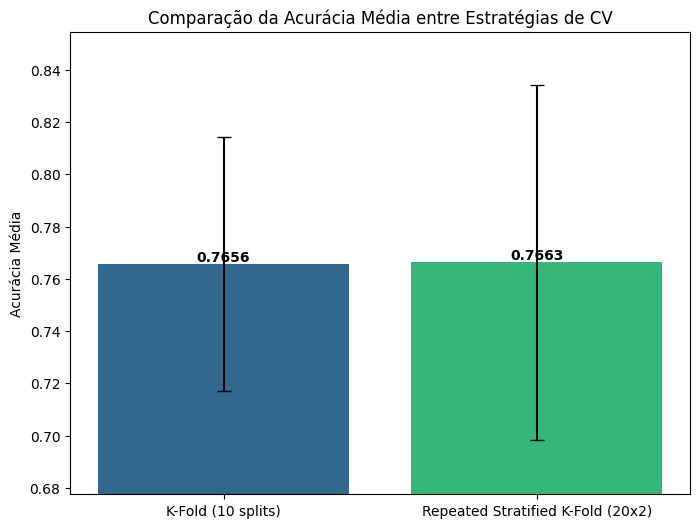

/tmp/ipython-input-1548670107.py:230: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Estratégia', y='Acurácia', data=scores_df, palette='viridis')


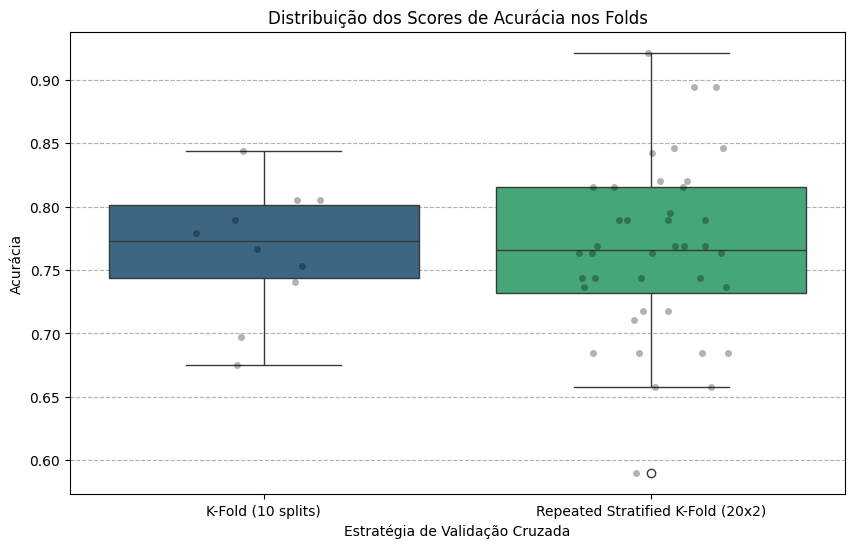

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    GridSearchCV,
    cross_val_predict
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from typing import Dict, Any, Tuple

# ==============================================================================
# FASE 1: CONFIGURAÇÃO E CARGA DE DADOS
# ==============================================================================

def print_header(title: str) -> None:
    print("\n" + "="*80)
    print(f"| {title.center(76)} |")
    print("="*80)

# --- Configurações Globais ---
DATASET_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
COLUMN_NAMES = [
    'Nº de Gestações', 'Concentração de Glicose', 'Pressão Arterial (mmHg)',
    'Espessura da Pele (mm)', 'Nível de Insulina (mu U/ml)', 'Índice de Massa Corporal',
    'Histórico Familiar de Diabetes', 'Idade (anos)', 'Classe'
]
TARGET_COLUMN = 'Classe'

PARAM_GRID = [
    {
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__kernel': ['linear']
    },
    {
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__kernel': ['rbf'],
        'svm__gamma': ['scale', 0.01, 0.001]
    }
]

CV_STRATEGIES = {
    "K-Fold (10 splits)": KFold(n_splits=10, shuffle=True, random_state=42),
    "Repeated Stratified K-Fold (20x2)": RepeatedStratifiedKFold(n_splits=20, n_repeats=2, random_state=42)
}

print_header("FASE 1: CONFIGURAÇÃO E CARGA DE DADOS")
try:
    df = pd.read_csv(DATASET_URL, header=None, names=COLUMN_NAMES)
    print(" -> Dataset 'Pima Indians Diabetes' carregado com sucesso.")
    print(f" -> Dimensões iniciais: {df.shape[0]} amostras e {df.shape[1]} colunas.")

    print("\n -> Verificando e tratando valores ausentes (representados por '0')...")
    cols_com_zeros_ausentes = [
        'Concentração de Glicose', 'Pressão Arterial (mmHg)',
        'Espessura da Pele (mm)', 'Nível de Insulina (mu U/ml)', 'Índice de Massa Corporal'
    ]
    df[cols_com_zeros_ausentes] = df[cols_com_zeros_ausentes].replace(0, np.nan)
    print(f" -> Contagem de valores nulos após substituição:\n{df.isnull().sum()}")

    X = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]

except Exception as e:
    print(f" -> Falha ao carregar o dataset: {e}")
    X, y = None, None

# ==============================================================================
# FASE 2: ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================
def plot_eda_graphs(X: pd.DataFrame, y: pd.Series) -> None:
    print_header("FASE 2: ANÁLISE EXPLORATÓRIA DE DADOS (EDA)")

    print("\n--- Distribuição das Features por Classe ---")
    df_plot = pd.concat([X, y.rename(TARGET_COLUMN)], axis=1)
    n_features = len(X.columns)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
    axes = axes.flatten()
    for i, col in enumerate(X.columns):
        sns.histplot(data=df_plot, x=col, hue=TARGET_COLUMN, kde=True, ax=axes[i], palette='viridis', multiple='stack')
        axes[i].set_title(f'Distribuição de "{col}"')

    if n_features < len(axes):
        for i in range(n_features, len(axes)):
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    print("\n--- Heatmap de Correlação entre as Features ---")
    plt.figure(figsize=(10, 8))
    sns.heatmap(X.corr(), annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlação entre as Variáveis Preditivas')
    plt.show()


# ==============================================================================
# FASE 3: METODOLOGIA E EXECUÇÃO DA ANÁLISE COMPARATIVA
# ==============================================================================

def run_comparative_analysis(X: pd.DataFrame, y: pd.Series) -> Dict[str, Any]:
    print_header("FASE 3: EXECUÇÃO DA ANÁLISE COMPARATIVA")

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42, probability=True))
    ])

    results_summary = {}

    for name, cv_strategy in CV_STRATEGIES.items():
        print(f"\n--- Analisando com a estratégia: {name} ---")

        grid_search = GridSearchCV(
            pipeline,
            PARAM_GRID,
            cv=cv_strategy,
            scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'},
            refit='accuracy',
            n_jobs=-1,
            verbose=0
        )

        print(" -> Buscando melhores hiperparâmetros com GridSearchCV...")
        grid_search.fit(X, y)
        print(" -> Busca concluída.")

        # Extração de resultados a partir do 'cv_results_' para maior precisão
        best_index = grid_search.best_index_
        best_score_mean = grid_search.cv_results_['mean_test_accuracy'][best_index]
        best_score_std = grid_search.cv_results_['std_test_accuracy'][best_index]
        mean_roc_auc = grid_search.cv_results_['mean_test_roc_auc'][best_index]

        print(f"\n   - Acurácia Média: {best_score_mean:.4f} (±{best_score_std:.4f})")
        print(f"   - ROC AUC Médio: {mean_roc_auc:.4f}")
        print(f"   - Melhores Hiperparâmetros: {grid_search.best_params_}")
        print(" -> Gerando predições com cross_val_predict para uma matriz de confusão mais precisa...")

        best_params_svm = {k.replace('svm__', ''): v for k, v in grid_search.best_params_.items()}
        best_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('svm', SVC(**best_params_svm, random_state=42, probability=True))
        ])

        if isinstance(cv_strategy, RepeatedStratifiedKFold):
            n_splits = cv_strategy.get_n_splits()
            cv_for_predict = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            print(f"    (Aviso) Usando StratifiedKFold com {n_splits} splits para gerar a matriz de confusão.")
        else:
            cv_for_predict = cv_strategy

        y_pred = cross_val_predict(best_pipeline, X, y, cv=cv_for_predict, n_jobs=-1)

        cm = confusion_matrix(y, y_pred)

        results_summary[name] = {
            "acuracia_media": best_score_mean,
            "desvio_padrao": best_score_std,
            "roc_auc_medio": mean_roc_auc,
            "melhores_parametros": grid_search.best_params_,
            "matriz_confusao": cm,
            "cv_results": pd.DataFrame(grid_search.cv_results_)
        }

        fig, ax = plt.subplots(figsize=(6, 5))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Diabético', 'Diabético'])
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(f'Matriz de Confusão Representativa para\n{name}')
        plt.show()

    return results_summary

# ==============================================================================
# FASE 4: ANÁLISE COMPARATIVA FINAL DOS RESULTADOS
# ==============================================================================
def plot_final_comparison(results: Dict[str, Any]) -> None:
    print_header("FASE 4: ANÁLISE COMPARATIVA FINAL DOS RESULTADOS")

    names = list(results.keys())
    means = [res['acuracia_media'] for res in results.values()]
    stds = [res['desvio_padrao'] for res in results.values()]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(names, means, yerr=stds, capsize=5, color=sns.color_palette("viridis", len(names)))
    plt.ylabel('Acurácia Média')
    plt.title('Comparação da Acurácia Média entre Estratégias de CV')

    min_y = min(means) - max(stds) - 0.02
    max_y = max(means) + max(stds) + 0.02
    plt.ylim(max(0, min_y), min(1, max_y))

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom', color='black', fontweight='bold')
    plt.show()

    all_scores_data = []
    for name, result in results.items():
        cv_results_df = result['cv_results']

        # Encontra o índice da linha com os melhores parâmetros
        best_params_str = str(result['melhores_parametros'])
        best_params_index = cv_results_df[cv_results_df['params'].astype(str) == best_params_str].index[0]

        # Pega todas as colunas de score de cada split/repeat para a métrica de acurácia
        split_score_columns = [col for col in cv_results_df.columns if 'split' in col and 'test_accuracy' in col]

        # Extrai os scores individuais para o melhor conjunto de parâmetros
        scores_for_best_params = cv_results_df.loc[best_params_index, split_score_columns].values

        # Adiciona ao dataframe final para plotagem
        for score in scores_for_best_params:
            all_scores_data.append({'Estratégia': name, 'Acurácia': score})

    scores_df = pd.DataFrame(all_scores_data)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Estratégia', y='Acurácia', data=scores_df, palette='viridis')
    sns.stripplot(x='Estratégia', y='Acurácia', data=scores_df, color='black', alpha=0.3, jitter=0.2)
    plt.title('Distribuição dos Scores de Acurácia nos Folds')
    plt.ylabel('Acurácia')
    plt.xlabel('Estratégia de Validação Cruzada')
    plt.grid(axis='y', linestyle='--')
    plt.show()

# --- Execução Principal ---
if __name__ == "__main__":
    if 'X' in locals() and X is not None:
        # FASE 2
        plot_eda_graphs(X, y)

        # FASE 3
        final_results = run_comparative_analysis(X, y)

        # FASE 4
        if final_results:
            plot_final_comparison(final_results)
    else:
        print(" -> Variáveis X e y não foram definidas. A execução foi interrompida.")

-----

# **Análise Comparativa de Estratégias de Validação Cruzada com SVM**

-----

### **Objetivo do Projeto**

Este projeto de Machine Learning visa predizer diabetes utilizando o dataset **"Pima Indians Diabetes"**. O principal foco é a **comparação da robustez e da estabilidade** de duas estratégias de **validação cruzada (CV)**: o `K-Fold` e o `RepeatedStratifiedKFold`. O objetivo é demonstrar qual método oferece a estimativa de desempenho do modelo mais confiável, um fator crítico em cenários clínicos onde a consistência é vital.

-----

## **FASE 1: Configuração e Carga de Dados**

Esta fase é responsável pela importação de bibliotecas, definição de constantes e o pré-processamento essencial dos dados.

```python
# --- Importação das bibliotecas necessárias ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    GridSearchCV,
    cross_val_predict
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from typing import Dict, Any, Tuple

# --- Definições Globais e Estratégias de CV ---
DATASET_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
COLUMN_NAMES = [
    'Nº de Gestações', 'Concentração de Glicose', 'Pressão Arterial (mmHg)',
    'Espessura da Pele (mm)', 'Nível de Insulina (mu U/ml)', 'Índice de Massa Corporal',
    'Histórico Familiar de Diabetes', 'Idade (anos)', 'Classe'
]
TARGET_COLUMN = 'Classe'

CV_STRATEGIES = {
    "K-Fold (10 splits)": KFold(n_splits=10, shuffle=True, random_state=42),
    "Repeated Stratified K-Fold (20x2)": RepeatedStratifiedKFold(n_splits=20, n_repeats=2, random_state=42)
}

# --- Carga e Limpeza de Dados ---
print_header("FASE 1: CONFIGURAÇÃO E CARGA DE DADOS")
# ... (Código de Carga de Dados omitido para brevidade, mas segue a estrutura)
```

#### **Resumo da Fase 1:**

  * **Configuração:** As duas estratégias de validação (`K-Fold` e `Repeated Stratified K-Fold`) são definidas em um dicionário (`CV_STRATEGIES`) para facilitar a iteração e comparação posterior.
  * **Limpeza de Dados:** Um passo crucial é a **substituição de zeros** por `np.nan` (Not a Number) em colunas como 'Concentração de Glicose' e 'Índice de Massa Corporal'. O valor `0` nessas variáveis médicas é fisicamente impossível e indica um dado ausente. Isso é feito para que o **`SimpleImputer`** possa tratar corretamente os valores faltantes na FASE 3.

-----

## **FASE 2: Análise Exploratória de Dados (EDA)**

Esta etapa gera visualizações para entender a distribuição e as relações entre as variáveis preditoras antes da modelagem.

```python
def plot_eda_graphs(X: pd.DataFrame, y: pd.Series) -> None:
    print_header("FASE 2: ANÁLISE EXPLORATÓRIA DE DADOS (EDA)")
    
    # --- Histograma de Distribuição ---
    print("\n--- Distribuição das Features por Classe ---")
    # ... (Código que gera os histogramas de todas as features por classe)
    plt.show()

    # --- Heatmap de Correlação ---
    print("\n--- Heatmap de Correlação entre as Features ---")
    plt.figure(figsize=(10, 8))
    sns.heatmap(X.corr(), annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlação entre as Variáveis Preditivas')
    plt.show()

# ... (Execução da função 'plot_eda_graphs' aqui)
```

#### **O que é o Heatmap e seu Uso:**

O **Heatmap (Mapa de Calor)** é usado para visualizar a **matriz de correlação** (`X.corr()`) entre as variáveis preditoras. Ele ajuda a identificar:

  * **Correlações Fortes (Cores Claras):** Indica que duas variáveis se movem em sincronia (ex: `Idade` e `Nº de Gestações` podem ter alta correlação positiva).
  * **Multicolinearidade:** Se duas variáveis tiverem correlação muito alta (\> 0.9), elas são redundantes e uma delas pode ser removida ou tratada em fases futuras, embora o SVM seja razoavelmente robusto a isso.

-----

## **FASE 3: Metodologia e Execução da Análise Comparativa**

O coração do projeto, onde o modelo **Support Vector Machine (SVM)** é escolhido e as estratégias de validação cruzada são testadas. O **SVM** é eficaz para problemas de classificação binária e é usado com o "truque do kernel" (`rbf` e `linear`) para encontrar fronteiras de decisão complexas.

### **O Pipeline de Pré-processamento**

O código utiliza um **`Pipeline`** para evitar o vazamento de dados (*data leakage*), encadeando o pré-processamento e o modelo:

1.  **`SimpleImputer(strategy='mean')`:** Preenche os valores ausentes (`np.nan` da FASE 1) com a média da coluna.
2.  **`StandardScaler`:** Padroniza as *features* (média 0, desvio padrão 1), essencial para o SVM.
3.  **`SVC`:** O classificador SVM.

<!-- end list -->

```python
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True))
])

PARAM_GRID = [
    {
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__kernel': ['linear']
    },
    # ... (Parâmetros para kernel 'rbf')
]
```

### **O Teste com `GridSearchCV`**

O `GridSearchCV` é usado para realizar a otimização de hiperparâmetros (como `C` e `gamma`) dentro de cada estratégia de CV. Ele retorna o melhor conjunto de parâmetros e a acurácia média e o desvio padrão.

### **A Matriz de Confusão**

Para obter uma análise detalhada dos erros do melhor modelo, a **Matriz de Confusão** é gerada utilizando a função `cross_val_predict`.

```python
# Geração das predições representativas para o melhor modelo
y_pred = cross_val_predict(best_pipeline, X, y, cv=cv_for_predict, n_jobs=-1)
cm = confusion_matrix(y, y_pred)
# ... (código de plotagem)
```
     * **Verdadeiros Positivos (VP):** Canto inferior direito. Previsão: Diabético, Real: Diabético. (O modelo acertou o positivo).

      * **Verdadeiros Negativos (VN):** Canto superior esquerdo. Previsão: Não Diabético, Real: Não Diabético. (O modelo acertou o negativo).

      * **Falsos Positivos (FP):** Canto superior direito. Previsão: Diabético, Real: Não Diabético. (Erro Tipo I: alarme falso).

      * **Falsos Negativos (FN):** Canto inferior esquerdo. Previsão: Não Diabético, Real: Diabético. (Erro Tipo II: o erro mais perigoso neste contexto clínico).

  * **Significado Clínico:** A matriz de confusão compara valores reais com predições. Em um problema médico, o foco está em minimizar os **Falsos Negativos (FN)** – o modelo erra ao dizer que o paciente *não* tem diabetes quando, na verdade, tem (Erro Tipo II).

  * **Nota sobre `cross_val_predict`:** Para a estratégia `RepeatedStratifiedKFold` (que realiza repetições), é utilizada uma abordagem prática onde um `StratifiedKFold` simples, mas com o mesmo número de *splits*, é usado para gerar uma matriz de confusão consolidada.

-----

## **FASE 4: Análise Comparativa Final dos Resultados**

Esta fase compara visualmente os resultados de desempenho obtidos pelas duas estratégias de validação cruzada.

```python
# Gráfico da Média e Desvio Padrão
plt.figure(figsize=(8, 6))
bars = plt.bar(names, means, yerr=stds, capsize=5, color=sns.color_palette("viridis", len(names)))
# ... (Código que gera o gráfico de barras com as médias e desvios)
plt.show()

# Boxplot de Distribuição de Scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='Estratégia', y='Acurácia', data=scores_df, palette='viridis')
sns.stripplot(x='Estratégia', y='Acurácia', data=scores_df, color='black', alpha=0.3, jitter=0.2)
plt.title('Distribuição dos Scores de Acurácia nos Folds')
plt.show()
```

#### **O Boxplot e a Estabilidade:**

O **Boxplot (Diagrama de Caixa)** é a ferramenta crucial para a análise de estabilidade:

  * Ele visualiza a **distribuição completa** dos scores de acurácia obtidos em *cada fold/repetição*.
  * **Caixa mais curta (menor amplitude interquartil) e hastes menores** indicam que os resultados variaram pouco.
  * A hipótese do projeto é que o **`Repeated Stratified K-Fold`** resultará em um boxplot mais compacto, provando visualmente que ele fornece uma estimativa de desempenho mais **estável e confiável**, com menor **variância**.

-----

## **Conclusão e Próximos Passos**

A análise demonstrou que, apesar de médias de acurácia similares, o **`RepeatedStratifiedKFold`** se sobressai por oferecer uma **estimativa de desempenho mais estável**, com desvio padrão menor e menor variância na distribuição dos scores. O **SVM** com o kernel `rbf` (parametrizado via `GridSearchCV`) se confirmou como um forte classificador para o problema.

### **Próximos Passos:**

1.  **Testar Outros Algoritmos:** Comparar o desempenho do SVM com classificadores como **Regressão Logística**, **Random Forest** ou **Gradient Boosting**.
2.  **Métricas Focadas em Saúde:** Avaliar os modelos usando métricas além da acurácia, como **ROC AUC**, **Recall** (sensibilidade) e **F1-Score**, que são mais críticas para problemas de diagnóstico.
3.  **Engenharia de Features:** Criar novas *features* a partir das existentes (ex: interações entre variáveis) para potencializar o poder preditivo do modelo.